<a href="https://colab.research.google.com/github/senasung37/project/blob/main/CP1_Project_AI07_%EC%84%B1%EC%84%B8%EC%9D%80_py.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#생성자 및 판별자 패키지
!pip install -q git+https://github.com/tensorflow/examples.git
!pip install tensorflow_addons
!pip install bing-image-downloader
!pip install tensorflow_examples

    Running setup.py install for tensorflow-examples ... done
  DEPRECATION: tensorflow-examples was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. You can find discussion regarding this at https://github.com/pypa/pip/issues/8368.
     |████████████████████████████████| 1.1 MB 5.2 MB/s 


In [2]:
#라이브러리 설치
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow_examples.models.pix2pix import pix2pix

import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output


#이전 프로젝트 라이브러리
from tensorflow import keras
from tensorflow.keras import layers,Sequential
import tensorflow_addons as tfa
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import numpy as np
import matplotlib as mlt
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

from sklearn.model_selection import train_test_split

import glob
import imageio
import PIL
import PIL.Image
import time

import shutil
from bing_image_downloader import downloader


In [3]:
#구글마운트
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#이미지 경로
path_train_kor = '/content/drive/MyDrive/interior2/train/train_kor'
path_train_scan = '/content/drive/MyDrive/interior2/train/train_scan'
path_test_kor = '/content/drive/MyDrive/interior2/test/test_kor'
path_test_scan = '/content/drive/MyDrive/interior2/test/test_scan'

path_train = '/content/drive/MyDrive/interior2/train'
path_test = '/content/drive/MyDrive/interior2/test'

In [5]:
#이미지 데이터셋으로 불러오기
train_kor = tf.keras.preprocessing.image_dataset_from_directory(path_train_kor, labels='inferred', label_mode='int', color_mode="rgb")
train_scan = tf.keras.preprocessing.image_dataset_from_directory(path_train_scan, labels='inferred', label_mode='int', color_mode="rgb")
test_kor = tf.keras.preprocessing.image_dataset_from_directory(path_test_kor, labels='inferred', label_mode='int', color_mode="rgb")
test_scan = tf.keras.preprocessing.image_dataset_from_directory(path_test_scan, labels='inferred', label_mode='int', color_mode="rgb")

Found 513 files belonging to 1 classes.
Found 554 files belonging to 1 classes.
Found 57 files belonging to 1 classes.
Found 57 files belonging to 1 classes.


In [6]:
#하이퍼파라미터
#Buffer_size: 셔플용, 데이터셋 수보다 많은 것이 좋음
BUFFER_SIZE = 2000
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [7]:
#함수 - 이미지 크랍
def random_crop(image):
  cropped_image = tf.image.random_crop(image, size=[BATCH_SIZE, IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image

In [8]:
#함수 - 이미지 리사이징, 크랍, 미러링(랜덤플립) -> 리사이징, 크랍은 오류로 인해 실행X
def random_jitter(image):  
  # random mirroring
  image = tf.image.random_flip_left_right(image)

  return image

In [9]:
#이미지 정규화
#normalizing the images to [-1, 1] 
#tf.cast: Casts a tensor to a new type(여기서는 이미지에서 float32로)
def normalize(image):
  image = tf.cast(image, tf.float32)
  image = (image / 127.5) - 1
  return image

In [10]:
#함수 - 이미지 프로세싱(이전 함수들 합침)
def preprocess_image_train(image, label):
  image = random_jitter(image)
  image = normalize(image)
  return image

def preprocess_image_test(image, label):
  image = normalize(image)
  return image

In [11]:
train_kor

<BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [12]:
tfds.disable_progress_bar()
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [13]:
#train, test 데이터셋 프로세싱, 셔플
#map(func, iter)
#num_parallel_calls: interleave argument -> Interleave: 성능을 높이기 위해 데이터가 서로 인접하지 않도록 배열하는 방법
#cache: dataset 캐쉬로 저장(epoch마다 불러오지 않도록)

train_kor = train_kor.map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).cache().shuffle(BUFFER_SIZE)

train_scan = train_scan.map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).cache().shuffle(BUFFER_SIZE)

test_kor = test_kor.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(BUFFER_SIZE)

test_scan = test_scan.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(BUFFER_SIZE)

In [14]:
train_kor

<ShuffleDataset element_spec=TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None)>

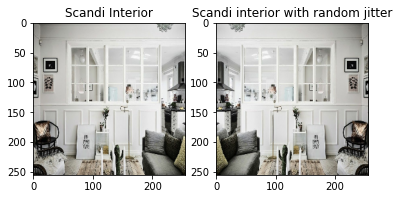

In [15]:
#샘플 이미지 만들기
sample_kor = next(iter(train_kor))
sample_scan = next(iter(train_scan))

plt.subplot(121)
plt.title('Scandi Interior')
plt.imshow(sample_scan[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Scandi interior with random jitter')
plt.imshow(random_jitter(sample_scan[0]) * 0.5 + 0.5)



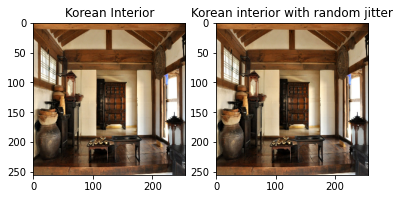

In [16]:
plt.subplot(121)
plt.title('Korean Interior')
plt.imshow(sample_kor[0] * 0.5 + 0.5)
plt.subplot(122)

plt.title('Korean interior with random jitter')
plt.imshow(random_jitter(sample_kor[0]) * 0.5 + 0.5)

##모델링

In [17]:
OUTPUT_CHANNELS = 3

generator_g = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_f = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

discriminator_x = pix2pix.discriminator(norm_type='instancenorm', target=False)
discriminator_y = pix2pix.discriminator(norm_type='instancenorm', target=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


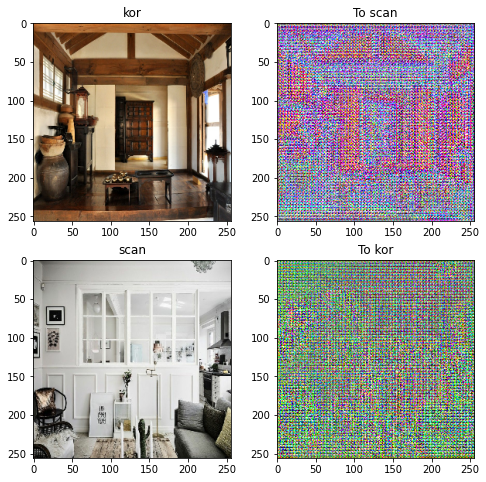

In [18]:
to_scan = generator_g(sample_kor)
to_kor = generator_f(sample_scan)
plt.figure(figsize=(8, 8))
contrast = 8

imgs = [sample_kor, to_scan, sample_scan, to_kor]
title = ['kor', 'To scan', 'scan', 'To kor']

for i in range(len(imgs)):
  plt.subplot(2, 2, i+1)
  plt.title(title[i])
  if i % 2 == 0:
    plt.imshow(imgs[i][0] * 0.5 + 0.5)
  else:
    plt.imshow(imgs[i][0] * 0.5 * contrast + 0.5)
plt.show()

In [19]:
#손실 함수
LAMBDA = 10
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

#판별자 손실함수: 실제손실+생성손실 
def discriminator_loss(real, generated):
  real_loss = loss_obj(tf.ones_like(real), real)
  generated_loss = loss_obj(tf.zeros_like(generated), generated)
  total_disc_loss = real_loss + generated_loss
  return total_disc_loss * 0.5

#생성자 손실함수: 생성손실
def generator_loss(generated):
  return loss_obj(tf.ones_like(generated), generated)

In [20]:
#재생 손실함수: 실제 이미지, 재생된 이미지 간의 오차의 평균
def calc_cycle_loss(real_image, cycled_image):
  loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

  return LAMBDA * loss1

In [21]:
#아이덴티티 손실함수
def identity_loss(real_image, same_image):
  loss = tf.reduce_mean(tf.abs(real_image - same_image))
  return LAMBDA * 0.5 * loss

In [22]:
#모든 생성기 및 판별자 옵티마이저 초기화
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [23]:
#체크포인트: 모델에서 사용한 파라미터 저장
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

In [24]:
def generate_images(model, test_input):
  prediction = model(test_input)

  plt.figure(figsize=(12, 12))

  display_list = [test_input[0], prediction[0]]
  title = ['Input Image', 'Predicted Image']

  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')    
    if (epoch + 1) % 10 == 0:
      plt.savefig("./cyclegan/generated_img_%03d_%d.png" % (epoch, i))
  plt.show()

In [25]:
#이미 만들어진 폴더 지우기
!rm -rf ./cyclegan
#새로운 폴더 만들기
!mkdir ./cyclegan

In [26]:
@tf.function
def train_step(real_x, real_y):
  # tf.GradientTape: 자동 미분(주어진 입력 변수에 대한 연산의 그래디언트를 계산하는 것)을 위한 API
  # persistent=True: the tape is used more than once to calculate the gradients.
  with tf.GradientTape(persistent=True) as tape:
    # Generator G translates X -> Y
    # Generator F translates Y -> X.
    # trainig=True: inference가 아닌 training 모드로 학습 진행
    fake_y = generator_g(real_x, training=True)
    cycled_x = generator_f(fake_y, training=True)

    fake_x = generator_f(real_y, training=True)
    cycled_y = generator_g(fake_x, training=True)

    # same_x and same_y are used for identity loss. 
    same_x = generator_f(real_x, training=True)
    same_y = generator_g(real_y, training=True)

    disc_real_x = discriminator_x(real_x, training=True)
    disc_real_y = discriminator_y(real_y, training=True)

    disc_fake_x = discriminator_x(fake_x, training=True)
    disc_fake_y = discriminator_y(fake_y, training=True)

    # calculate the loss
    gen_g_loss = generator_loss(disc_fake_y)
    gen_f_loss = generator_loss(disc_fake_x)

    total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)

    # Total generator loss = adversarial loss + cycle loss
    total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
    total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

    disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
    disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

  # Calculate the gradients for generator and discriminator
  # trainable_variables: Returns all variables created with trainable=True
  generator_g_gradients = tape.gradient(total_gen_g_loss, 
                                        generator_g.trainable_variables)
  generator_f_gradients = tape.gradient(total_gen_f_loss, 
                                        generator_f.trainable_variables)

  discriminator_x_gradients = tape.gradient(disc_x_loss, 
                                            discriminator_x.trainable_variables)
  discriminator_y_gradients = tape.gradient(disc_y_loss, 
                                            discriminator_y.trainable_variables)

  # Apply the gradients to the optimizer
  generator_g_optimizer.apply_gradients(zip(generator_g_gradients, 
                                            generator_g.trainable_variables))

  generator_f_optimizer.apply_gradients(zip(generator_f_gradients, 
                                            generator_f.trainable_variables))

  discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                discriminator_x.trainable_variables))

  discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                discriminator_y.trainable_variables))

In [27]:
def generate_images(model, test_input, epoch):
  prediction = model(test_input)

  plt.figure(figsize=(12, 12))

  display_list = [test_input[0], prediction[0]]
  title = ['Input Image', 'Predicted Image']
   
  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')

    if (epoch + 1) % 10 == 0:
      plt.savefig("./cyclegan/generated_img_%03d_%d.png" % (epoch, i))
      
  plt.show()



In [28]:
#훈련(논문에선 200 epochs 사용)
EPOCHS = 100

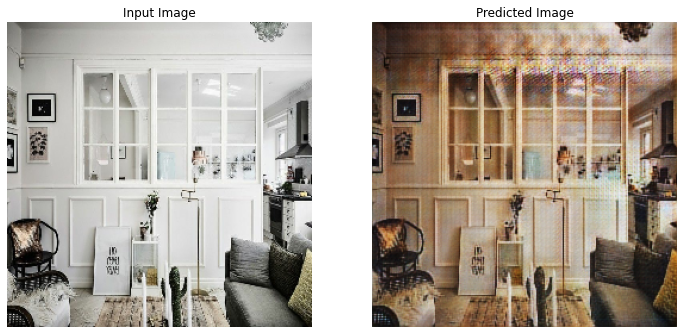

Saving checkpoint for epoch 100 at ./checkpoints/train/ckpt-20
Time taken for epoch 100 is 43.40751791000366 sec



In [29]:
#cylegan 모델로 변형 이미지 생성
for epoch in range(EPOCHS):
  print(f'{epoch}th epoch', end=',')
  start = time.time()

  n = 0
  for image_x, image_y in tf.data.Dataset.zip((train_kor, train_scan)):
    train_step(image_x, image_y)
    n+=1

  clear_output(wait=True)
  # Using a consistent image (sample_scan) so that the progress of the model
  # is clearly visible.
  generate_images(generator_f, sample_scan, epoch)

  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))
    print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                      time.time()-start))

In [ ]:
generator_f.summary()

In [31]:
!cp cyclegan -r "/content/drive/MyDrive/interior2/cyclegan_generatedimg"

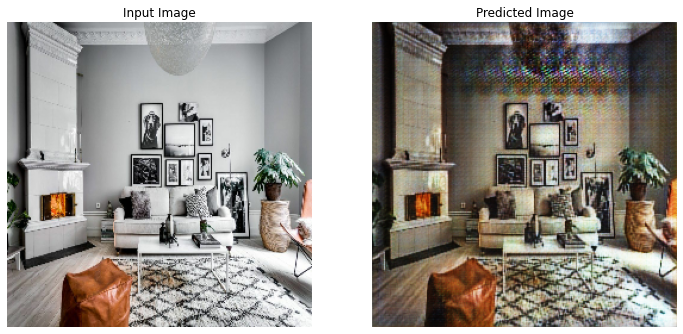

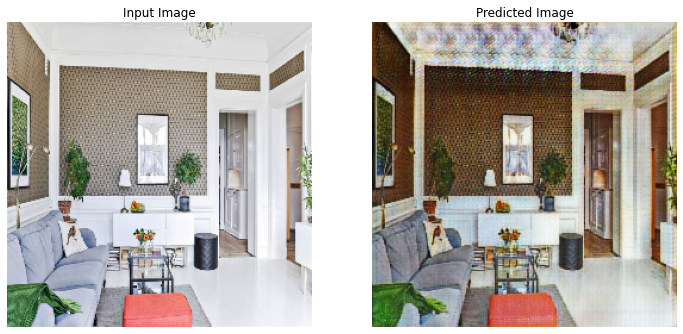

In [32]:
# Run the trained model on the test dataset
for inp in test_scan.take(5):
  generate_images(generator_f, inp, EPOCHS)